# Ensemble and Stacking technique in Titanik competition

In [1]:
# Load in libraries

In [2]:
import pandas as pd
import numpy as np
import re
import sklearn
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

import warnings
warnings.filterwarnings('ignore')

# Goint to use these 5 base models for the stacking
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier)
from sklearn.svm import SVC
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve
from sklearn.linear_model import LinearRegression

## PDA, Feature engineering and cleaning

In [3]:
train = pd.read_csv('./Dataset/train.csv')
test = pd.read_csv('./Dataset/test.csv')
train.head(20)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [4]:
dataset = pd.concat([train,test],axis=0,sort=True)

In [5]:
print(train.shape)
print(test.shape)
print(dataset.shape)

(891, 12)
(418, 11)
(1309, 12)


In [6]:
dataset.describe()

,Age,Fare,Parch,PassengerId,Pclass,SibSp,Survived
count,1046.000000,1308.000000,1309.000000,1309.000000,1309.000000,1309.000000,891.000000
mean,29.881138,33.295479,0.385027,655.000000,2.294882,0.498854,0.383838
std,14.413493,51.758668,0.865560,378.020061,0.837836,1.041658,0.486592
min,0.170000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
25%,21.000000,7.895800,0.000000,328.000000,2.000000,0.000000,0.000000
50%,28.000000,14.454200,0.000000,655.000000,3.000000,0.000000,0.000000
75%,39.000000,31.275000,0.000000,982.000000,3.000000,1.000000,1.000000
max,80.000000,512.329200,9.000000,1309.000000,3.000000,8.000000,1.000000


In [7]:
dataset.isnull().sum()

Age             263
Cabin          1014
Embarked          2
Fare              1
Name              0
Parch             0
PassengerId       0
Pclass            0
Sex               0
SibSp             0
Survived        418
Ticket            0
dtype: int64

In [8]:
dataset['Fare'][dataset['Fare'].isnull()] = dataset['Fare'].mean()
dataset['Fare'].isnull().sum()

0

In [9]:
dataset['Embarked'].value_counts()

S    914
C    270
Q    123
Name: Embarked, dtype: int64

In [10]:
dataset['Embarked'][dataset['Embarked'].isnull()] = 'S'

In [11]:
dataset['Embarked'].isnull().sum()

0

<AxesSubplot:>

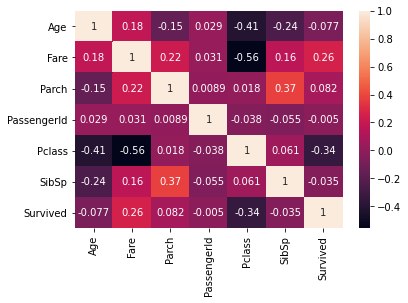

In [12]:
sns.heatmap(dataset.corr(), annot=True)

In [13]:
# Age prediction part
age_train_x = pd.concat([dataset['Fare'], dataset['Parch'], dataset['Pclass'], dataset['SibSp']], axis=1)
age_test_x = age_train_x[dataset['Age'].isnull()]
age_train_x = age_train_x[dataset['Age'].notnull()]
age_train_y = dataset['Age'][dataset['Age'].notnull()]
print(dataset['Age'].isnull())

0      False
1      False
2      False
3      False
4      False
       ...  
413     True
414    False
415    False
416     True
417     True
Name: Age, Length: 1309, dtype: bool


In [14]:
dataset.isnull().sum()

Age             263
Cabin          1014
Embarked          0
Fare              0
Name              0
Parch             0
PassengerId       0
Pclass            0
Sex               0
SibSp             0
Survived        418
Ticket            0
dtype: int64

In [15]:
age_train_x.isnull().sum()

Fare      0
Parch     0
Pclass    0
SibSp     0
dtype: int64

In [16]:
age_train_y.isnull().sum()

0

In [17]:
print(age_train_x.shape)
print(age_train_y.shape)
print(len(age_train_x))
age_train_y.head()
age_train_y.astype('int')

(1046, 4)
(1046,)
1046


0      22
1      38
2      26
3      35
4      35
       ..
409     3
411    37
412    28
414    39
415    38
Name: Age, Length: 1046, dtype: int32

In [18]:
linear_Regression = LinearRegression(fit_intercept=True, n_jobs=None)
linear_Regression.fit(age_train_x, age_train_y)
predict=linear_Regression.predict(age_test_x)
predict = abs(predict)
print(predict)

[26.55394797 33.40770335 26.55560771 26.55560771 26.55472731 26.55470497
 36.95353413 26.55490118 26.55560206 26.55470497 26.55449745 23.41012264
 26.55490118 20.26745802 40.23729105 40.24776004 22.23275721 26.55470497
 26.55449745 26.55485072 26.55449745 26.55449745 26.55470497 26.55486754
 23.39848176 26.55449745 26.55490118 22.22318544 24.18939854 26.55548995
 26.55367317  0.95847308 39.03334108 40.25017677 15.95030455  0.95847308
 33.40494453 40.21777744 23.41012264 26.55490118 26.55490118  0.95847308
 23.42055233 26.55470497 15.95030455 26.55517033 23.41153004 23.41012264
 26.55557406 40.17848106 26.55490118 26.55490118 40.243347   26.55490118
 33.42519832 40.25007583 40.24776004 40.24401988 26.55490118 20.26534409
 33.4085781  26.55449745 40.13584274  0.95847308 20.26534409 36.97085522
 26.55470497 23.40931518 40.23796394 26.55560771 26.55472731 26.55472731
 23.41012264 26.55560206 26.55490118 37.0401342  26.55470497 26.55492917
 15.95030455 26.55470497 26.5561012  33.42519832 26

In [19]:
dataset['Age'][dataset['Age'].isnull()] = predict

In [20]:
dataset.isnull().sum()

Age               0
Cabin          1014
Embarked          0
Fare              0
Name              0
Parch             0
PassengerId       0
Pclass            0
Sex               0
SibSp             0
Survived        418
Ticket            0
dtype: int64